In [ ]:
pip install comet-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.3/682.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.2.0
    Uninstalling python-box-7.2.0:
      Successfully uninstalled python-box-7.2.0


In [ ]:
import os
import copy
import pdb
import itertools
import random
import string
import math
from pathlib import Path
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torch.nn.utils.weight_norm as weightNorm
from torch.nn.functional import relu, avg_pool2d
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import Sampler, RandomSampler
import torchvision.transforms.functional as TorchVisionFunc
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset, Subset

from comet_ml import Experiment

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def save_model(model, path):
    torch.save(model.cpu(), path)

def load_model(path):
    model = torch.load(path)
    return model

def setup_experiment(experiment, config):
    Path(f"./checkpoints/{config['dataset']}").mkdir(parents=True, exist_ok=True)
    init_model = ResNet18(config=config) if 'cifar' in config['dataset'] else MLP(config)
    save_model(init_model, f"./checkpoints/{config['dataset']}/init.pth")
    experiment.log_parameters(config)

# Compute Grads

In [ ]:
def flatten_grads(m, numpy_output=False, bias=True, only_linear=False):
    total_grads = []
    for name, param in m.named_parameters():
        if only_linear:
            if (bias or not 'bias' in name) and 'linear' in name:
                total_grads.append(param.grad.detach().view(-1))
        else:
            if (bias or not 'bias' in name) and not 'bn' in name and not 'IC' in name:
                try:
                    total_grads.append(param.grad.detach().view(-1))
                except AttributeError:
                    pass

    total_grads = torch.cat(total_grads)
    if numpy_output:
        return total_grads.cpu().detach().numpy()
    return total_grads


def compute_and_flatten_example_grads(m, criterion, data, target, task_id):
    _eg = []
    criterion2 = nn.CrossEntropyLoss(reduction='none').to(DEVICE)
    m.eval()
    m.zero_grad()
    pred = m(data, task_id)
    loss = criterion2(pred, target)
    for idx in range(len(data)):
        loss[idx].backward(retain_graph=True)
        _g = flatten_grads(m, numpy_output=True)
        _eg.append(torch.Tensor(_g))
        m.zero_grad()
    return torch.stack(_eg)

def flatten_example_grads(m, numpy_output=False):
    total_grads = []
    for param in m.parameters():
            total_grads.append(param.grad1.view(param.grad1.size()[0], -1))
    total_grads = torch.cat(total_grads, 1)
    if numpy_output:
        return total_grads.cpu().detach().numpy()
    return total_grads

# Coreset Selection

In [ ]:
def sample_selection(g, eg):
    ng = torch.norm(g)
    neg = torch.norm(eg, dim=1)
    mean_sim = torch.matmul(g,eg.t()) / torch.maximum(ng*neg, torch.ones_like(neg)*1e-6)
    negd = torch.unsqueeze(neg, 1)

    cross_div = torch.matmul(eg,eg.t()) / torch.maximum(torch.matmul(negd, negd.t()), torch.ones_like(negd)*1e-6)
    mean_div = torch.mean(cross_div, 0)

    measure = mean_sim - mean_div
    _, u_idx = torch.sort(measure, descending=True)
    return u_idx.cpu().numpy()


In [ ]:
def classwise_fair_selection(task, cand_target, sorted_index, num_per_label, config, is_shuffle=True):
    num_examples_per_task = config['memory_size'] // task
    num_examples_per_class = num_examples_per_task // config['n_classes']
    num_residuals = num_examples_per_task - num_examples_per_class * config['n_classes']
    residuals =  np.sum([(num_examples_per_class - n_c)*(num_examples_per_class > n_c) for n_c in num_per_label])
    num_residuals += residuals

    # Get the number of coreset instances per class
    while True:
        n_less_sample_class =  np.sum([(num_examples_per_class > n_c) for n_c in num_per_label])
        num_class = (config['n_classes']-n_less_sample_class)
        if (num_residuals // num_class) > 0:
            num_examples_per_class += (num_residuals // num_class)
            num_residuals -= (num_residuals // num_class) * num_class
        else:
            break
    # Get best coresets per class
    selected = []
    target_tid = np.floor(max(cand_target)/config['n_classes'])

    for j in range(config['n_classes']):
        position = np.squeeze((cand_target[sorted_index]==j+(target_tid*config['n_classes'])).nonzero())
        if position.numel() > 1:
            selected.append(position[:num_examples_per_class])
        elif position.numel() == 0:
            continue
        else:
            selected.append([position])
    # Fill rest space as best residuals
    selected = np.concatenate(selected)
    unselected = np.array(list(set(np.arange(num_examples_per_task))^set(selected)))
    final_num_residuals = num_examples_per_task - len(selected)
    best_residuals = unselected[:final_num_residuals]
    selected = np.concatenate([selected, best_residuals])

    if is_shuffle:
        random.shuffle(selected)

    return sorted_index[selected.astype(int)]

In [ ]:
def select_coreset(loader, task, model, candidates, config, candidate_size=250, fair_selection=True):
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    temp_optimizer = torch.optim.SGD(model.parameters(), lr=config['seq_lr'], momentum=config['momentum'])
    temp_optimizer.zero_grad()

    if fair_selection:
        # collect candidates
        cand_data, cand_target = [], []
        cand_size = len(candidates)
        for batch_idx, (data, target, task_id) in enumerate(loader['sequential'][task]['train']):
            if batch_idx == cand_size:
                break
            try:
                cand_data.append(data[candidates[batch_idx]])
                cand_target.append(target[candidates[batch_idx]])
            except IndexError:
                pass
        cand_data = torch.cat(cand_data, 0)
        cand_target = torch.cat(cand_target, 0)

        random_pick_up = torch.randperm(len(cand_target))[:candidate_size]
        cand_data = cand_data[random_pick_up]
        cand_target = cand_target[random_pick_up]

        num_per_label = [len((cand_target==(jj+config['n_classes']*(task-1))).nonzero()) for jj in range(config['n_classes'])]
        #print('num samples per label', num_per_label)

        num_examples_per_task = config['memory_size'] // task
        pred = model(cand_data.to(DEVICE), task)
        loss = criterion(pred, cand_target.long().to(DEVICE))
        loss.backward()

        # Coreset update
        _eg = compute_and_flatten_example_grads(model, criterion, cand_data.to(DEVICE), cand_target.long().to(DEVICE), task)
        _g = torch.mean(_eg, 0)
        sorted = sample_selection(_g, _eg)

        pick = torch.randperm(len(sorted))
        selected = classwise_fair_selection(task, cand_target, pick, num_per_label, config, is_shuffle=True)

        loader['coreset'][task]['train'].data = copy.deepcopy(cand_data[selected])
        loader['coreset'][task]['train'].targets = copy.deepcopy(cand_target[selected])
        num_per_label = [len((cand_target[selected]==(jj+config['n_classes']*(task-1))).nonzero()) for jj in range(config['n_classes'])]
        #print('after select_coreset, num samples per label', num_per_label)
    else:
        pass


In [ ]:
def reconstruct_coreset_loader(config, dataset, task):
    trains = []
    all_coreset = {}

    for tid in range(1, task+1):
        num_examples_per_task = config['memory_size'] // task
        coreset = Coreset(num_examples_per_task, input_shape=[3, 32, 32])

        pick_idx = torch.randperm(num_examples_per_task)
        coreset.data = copy.deepcopy(dataset[tid]['train'].data[pick_idx])
        coreset.targets = copy.deepcopy(dataset[tid]['train'].targets[pick_idx])
        coreset_loader = torch.utils.data.DataLoader(coreset, batch_size=config['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
        train_loader = fast_cifar_loader(coreset_loader, tid, eval=False)
        if ('cifar' in config['dataset']):
            train_loader = fast_cifar_loader(coreset_loader, tid, eval=False)
        else:
            train_loader = fast_mnist_loader(coreset_loader, eval=False)
        trains += train_loader
    all_coreset = random.sample(trains[:], len(trains))
    return all_coreset


def get_coreset_loss(model, iterloader, config):
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    model.train()
    coreset_loss = 0
    count = 0
    data, target, task_id = iterloader
    count += len(target)
    data = data.to(DEVICE)
    target = target.to(DEVICE)
    output = model(data, task_id)
    coreset_loss += criterion(output, target.long())
    coreset_loss /= count
    return coreset_loss


In [ ]:
def update_coreset(loader, task, model, task_id, config):
    # Coreset update
    num_examples_per_task = config['memory_size'] // task
    prv_nept = config['memory_size'] // (task-1)

    for tid in range(1, task):
        criterion = nn.CrossEntropyLoss().to(DEVICE)
        temp_optimizer = torch.optim.SGD(model.parameters(), lr=config['seq_lr'], momentum=config['momentum'])

        tid_coreset = loader['coreset'][tid]['train'].data
        tid_targets = loader['coreset'][tid]['train'].targets

        temp_optimizer.zero_grad()

        pred = model(tid_coreset.to(DEVICE), task_id)
        loss = criterion(pred, tid_targets.long().to(DEVICE))
        loss.backward()
        _tid_eg = compute_and_flatten_example_grads(model, criterion, tid_coreset.to(DEVICE), tid_targets.to(DEVICE), tid)
        _tid_g = torch.mean(_tid_eg, 0)
        pick = sample_selection(_tid_g, _tid_eg)

        class_idx = [tid_targets.cpu().numpy() == i for i in range(config['n_classes'])]
        num_per_label = [len((tid_targets.cpu()==(jj+config['n_classes']*(task-1))).nonzero()) for jj in range(config['n_classes'])]

        selected = classwise_fair_selection(task, tid_targets, pick, num_per_label, config)
        _nn = [len((tid_targets[selected]==(jj+config['n_classes']*(tid-1))).nonzero()) for jj in range(config['n_classes'])]

        loader['coreset'][tid]['train'].data = copy.deepcopy(loader['coreset'][tid]['train'].data[selected])
        loader['coreset'][tid]['train'].targets = copy.deepcopy(loader['coreset'][tid]['train'].targets[selected])


# Train

In [ ]:
def train_single_step(model, optimizer, loader, task, step, config):
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    is_last_step = True if step == config['n_substeps'] else False
    candidates_indices=[]
    for batch_idx, (data, target, task_id) in enumerate(loader['sequential'][task]['train']):
        model.train()
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        is_ocspick = True if (config['ocspick'] and len(data) > config['batch_size']) else False
        optimizer.zero_grad()
        if is_ocspick and step != 1:
            _eg = compute_and_flatten_example_grads(model, criterion, data, target, task_id)
            _g = torch.mean(_eg, 0)
            sorted = sample_selection(_g, _eg, config)
            pick = sorted[:config['batch_size']]
            optimizer.zero_grad()
            pred = model(data[pick], task_id)
            loss = criterion(pred, target[pick])
            loss.backward()

            # Select coresets at final step
            if is_last_step:
                candidates_indices.append(pick)
        else:
            size = min(len(data), config['batch_size'])
            pick = torch.randperm(len(data))[:size]
            pred = model(data[pick], task_id)
            loss = criterion(pred, target[pick])
            loss.backward()
        optimizer.step()

    if is_last_step:
        select_coreset(loader, task, model, candidates_indices, config)
    return model


In [ ]:
def train_ocs_single_step(model, optimizer, loader, task, step, config):
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    is_last_step = step == config['n_substeps']

    # Concatenate previous task data and targets
    prev_coreset = [loader['coreset'][tid]['train'].data for tid in range(1, task)]
    prev_targets = [loader['coreset'][tid]['train'].targets for tid in range(1, task)]
    c_x = torch.cat(prev_coreset, 0)
    c_y = torch.cat(prev_targets, 0)

    ref_loader = reconstruct_coreset_loader(config, loader['coreset'], task - 1)
    ref_iterloader = itertools.cycle(ref_loader)  # Create an iterator that cycles through ref_loader

    candidates_indices = []

    for batch_idx, (data, target, task_id) in enumerate(loader['sequential'][task]['train']):
        model.eval()
        optimizer.zero_grad()
        is_rand_start = step == 1

        # Compute reference gradients
        ref_pred = model(c_x.to(DEVICE), task)
        ref_loss = criterion(ref_pred, c_y.long().to(DEVICE))
        ref_loss.backward()
        ref_grads = copy.deepcopy(flatten_grads(model))
        optimizer.zero_grad()

        data = data.to(DEVICE)
        target = target.to(DEVICE)

        if is_rand_start:
            size = min(len(data), config['batch_size'])
            pick = torch.randperm(len(data))[:size]
        else:
            # Compute example gradients and select samples
            _eg = compute_and_flatten_example_grads(model, criterion, data, target, task_id)
            _g = torch.mean(_eg, 0)
            sorted_indices = sample_selection(_g.cuda(), _eg.cuda(), config, ref_grads=ref_grads)
            pick = sorted_indices[:config['batch_size']]

        model.train()
        optimizer.zero_grad()
        pred = model(data[pick], task_id)
        loss = criterion(pred, target[pick])

        ref_data = next(ref_iterloader)
        ref_loss = get_coreset_loss(model, ref_data, config)
        loss += config['ref_hyp'] * ref_loss
        loss.backward()
        optimizer.step()

        if is_last_step:
            candidates_indices.append(pick)

    if is_last_step:
        select_coreset(loader, task, model, candidates_indices, config)
        update_coreset(loader, task, model, task_id, config)

    return model

In [ ]:
def eval_single_epoch(model, loader, config):
    model.to(DEVICE)
    model.eval()

    criterion = nn.CrossEntropyLoss().to(DEVICE)
    total_loss, correct, total_samples = 0.0, 0, 0

    class_correct = np.zeros(config['n_classes'])
    class_total = np.zeros(config['n_classes'])

    with torch.no_grad():
        for data, target, task_id in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data, task_id)
            loss = criterion(output, target)

            total_loss += loss.item() * len(target)
            total_samples += len(target)

            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()

            for cid in range(config['n_classes']):
                cid_index = (target == cid) if 'cifar' not in config['dataset'] else (target == cid + (task_id - 1) * config['n_classes'])
                class_correct[cid] += (preds == target)[cid_index].sum().item()
                class_total[cid] += cid_index.sum().item()

    avg_loss = total_loss / total_samples
    avg_acc = 100.0 * correct / total_samples
    per_class_acc = [round(100.0 * a / b, 4) if b > 0 else 0.0 for a, b in zip(class_correct, class_total)]

    return {'accuracy': avg_acc, 'per_class_accuracy': per_class_acc, 'loss': avg_loss}


In [ ]:
def train_task_sequentially(task, train_loader, config, summary=None):
    current_lr = config['seq_lr'] * (config['lr_decay'])**(task-1)
    prev_model_path = f"./checkpoints/{config['dataset']}/init.pth"
    model = load_model(prev_model_path).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=current_lr, momentum=config['momentum'])
    config['n_substeps'] = int((config['stream_size'] / config['batch_size']))
    for _step in range(1, config['n_substeps']+1):
        if task == 1 or (config['ocspick'] == False):
            model = train_single_step(model, optimizer, train_loader, task, _step, config)
        else:
            model = train_ocs_single_step(model, optimizer, train_loader, task, _step, config)
        metrics = eval_single_epoch(model, train_loader['sequential'][task]['val'], config)
        print('Epoch {} >> (per-task accuracy): {}'.format(_step/config['n_substeps'], np.mean(metrics['accuracy'])))
        print('Epoch {} >> (class accuracy): {}'.format(_step/config['n_substeps'], metrics['per_class_accuracy']))
    return model


# Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.save_acts = False
        self.acts = {}
        self.config = config
        self.W1 = nn.Linear(784, config['mlp_hiddens'])
        self.dropout_1 =  nn.Dropout(p=config['dropout'])
        self.relu = nn.ReLU(inplace=True)
        self.W2 = nn.Linear(config['mlp_hiddens'], config['mlp_hiddens'])
        self.dropout_2 =  nn.Dropout(p=config['dropout'])

        self.W3 = nn.Linear(config['mlp_hiddens'], 10)
        # self.dropout_p = config['dropout']

    def embed(self, x):
        out = self.W1(x)
        out = self.relu(out)

        if self.save_acts:
            self.acts['layer 1'] = out.detach().clone()

        if self.config['dropout'] > 0:
            out = self.dropout_1(out)
        out = self.W2(out)
        self.feature = self.relu(out)
        if self.save_acts:
            self.acts['layer 2'] = self.feature.detach().clone()
        if self.config['dropout'] > 0:
            out = self.dropout_2(self.feature)
        return out


    def forward(self, x, task_id=None):
        # x = x.view(-1, 784 + self.num_condition_neurons)
        out = self.embed(x)
        out = self.W3(self.feature)
        # out = nn.functional.dropout(out, p=self.dropout_p)
        return out

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, config={}):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
            )
        self.IC1 = nn.Sequential(
            nn.BatchNorm2d(planes, track_running_stats=False),
            nn.Dropout(p=config['dropout'])
            )

        self.IC2 = nn.Sequential(
            nn.BatchNorm2d(planes, track_running_stats=False),
            nn.Dropout(p=config['dropout'])
            )

    def forward(self, x):
        out = self.conv1(x)
        out = relu(out)
        out = self.IC1(out)

        out += self.shortcut(x)
        out = relu(out)
        out = self.IC2(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf, config={}):
        super(ResNet, self).__init__()
        self.in_planes = nf
        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1, track_running_stats=False)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1, config=config)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2, config=config)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2, config=config)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2, config=config)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)
        self.config =config

    def _make_layer(self, block, planes, num_blocks, stride, config):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, config=config))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def embed(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

    def forward(self, x, task_id):
        out = self.embed(x)
        out = self.linear(out)
        t = task_id
        if isinstance(self.config['n_classes'], int):
            offset1 = int((t-1) * 5)
            offset2 = int(t * 5)
            if offset1 > 0:
                out[:, :offset1].data.fill_(-10e10)
            if offset2 < 100:
                out[:, offset2:100].data.fill_(-10e10)
            return out
        else:
            offsets = [sum(self.config['n_classes'][:c]) for c in range(1,len(self.config['n_classes'])+1)]
            offset1 = int(offsets[t-1])
            offset2 = int(offsets[t])
            if offset1 > 0:
                out[:, :offset1].data.fill_(-10e10)
            if offset2 < offsets[-1]:
                out[:, offset2:offsets[-1]].data.fill_(-10e10)
            return out

def ResNet18(nclasses=100, nf=20, config={}):
    net = ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf, config=config)
    return net

# ِDataset


# MNIST

In [ ]:
class RotationTransform:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, x):
        return TorchVisionFunc.rotate(x, self.angle, fill=(0,))

def fast_mnist_loader(loaders, eval=True, device='cpu'):
    trains, evals = [], []
    if eval:
        train_loader, eval_loader = loaders
        for data, target in train_loader:
            data = data.to(device).view(-1, 784)
            target = target.to(device)
            trains.append([data, target, None])

        for data, target in eval_loader:
            data = data.to(device).view(-1, 784)
            target = target.to(device)
            evals.append([data, target, None])
        return trains, evals
    else:
        train_loader = loaders

        for data, target in train_loader:
            data = data.to(device).view(-1, 784)
            target = target.to(device)
            trains.append([data, target, None])
        return trains

def get_balanced_noisy_rotated_mnist(task_id, batch_size, per_task_rotation):
    print('Noisy Rotated MNIST')
    rotation_degree = (task_id - 1)*per_task_rotation

    train_transforms = torchvision.transforms.Compose([
        RotationTransform(rotation_degree),
        torchvision.transforms.ToTensor(),
        ])

    test_transforms = torchvision.transforms.Compose([
        RotationTransform(rotation_degree),
        torchvision.transforms.ToTensor(),
        ])

    train_dataset = MNIST('./data/', train=True, download=True, transform=train_transforms)
    test_dataset = MNIST('./data/', train=False, download=True, transform=test_transforms)
    end_idx = int(len(train_dataset.data) * 0.6)
    shuffle = torch.randperm(len(train_dataset.data))
    idx = shuffle[:end_idx].long()
    for i in idx:
        train_dataset.data[i] = torch.randn(train_dataset.data[i].size())

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(MNIST('./data/', train=False, download=True, transform=test_transforms),  batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, test_loader


def get_rotated_mnist(task_id, batch_size, per_task_rotation):
    print('Rotated MNIST')
    rotation_degree = (task_id - 1)*per_task_rotation

    transforms = torchvision.transforms.Compose([
        RotationTransform(rotation_degree),
        torchvision.transforms.ToTensor(),
        ])

    train_loader = torch.utils.data.DataLoader(MNIST('./data/', train=True, download=True, transform=transforms), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(MNIST('./data/', train=False, download=True, transform=transforms),  batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, test_loader



# CIFAR100

In [ ]:
def fast_cifar_loader(loaders, task_id, eval=True, device='cpu'):
    trains, evals = [], []
    if eval:
        train_loader, eval_loader = loaders
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)
            trains.append([data, target, task_id])

        for data, target in eval_loader:
            data = data.to(device)
            target = target.to(device)
            evals.append([data, target, task_id])
        return trains, evals
    else:
        for data, target in loaders:
            data = data.to(device)
            target = target.to(device)
            trains.append([data, target, task_id])
        return trains

import torch
import numpy as np
from torch.utils.data import DataLoader, Subset

def get_split_cifar100(task_id, batch_size, cifar_train, cifar_test):
    # Calculate class range for the task
    start_class = (task_id - 1) * 5
    end_class = task_id * 5

    # Get indices of samples belonging to the current task's classes
    train_indices = np.where((np.array(cifar_train.targets) >= start_class) &
                             (np.array(cifar_train.targets) < end_class))[0]

    test_indices = np.where((np.array(cifar_test.targets) >= start_class) &
                            (np.array(cifar_test.targets) < end_class))[0]

    # Create DataLoader for the training and testing subsets
    train_loader = DataLoader(Subset(cifar_train, train_indices),
                              batch_size=batch_size, shuffle=True)

    test_loader = DataLoader(Subset(cifar_test, test_indices),
                             batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


def get_imbalanced_split_cifar100(task_id, batch_size, cifar_train, cifar_test):
    # Predefined shuffle of classes to introduce imbalance
    class_shuffle = [25, 11, 23, 76, 12, 30, 62,  6, 89, 44, 84, 29, 82,  3, 10, 24, 64, 72,
                     21,  8, 63, 71, 68, 74,  5, 86, 22, 58, 95, 19, 47, 54, 56,  2, 20, 96,
                     57, 38, 80, 66,  1, 59, 16, 97, 18, 73, 31, 77, 99, 15, 46, 27, 83, 40,
                     48, 88, 33, 36, 81, 55, 85, 14, 13,  7, 65, 50, 78, 43, 91,  4, 69, 52,
                     41, 94, 34, 51, 37,  9, 90, 35, 92, 26, 42,  0, 17, 87, 53, 93, 32, 28,
                     75, 67, 49, 79, 61, 60, 70, 98, 45, 39]

    n_class = 100
    img_max = len(cifar_train.targets) // n_class
    imb_factor = 1 / 10.

    # Create imbalanced indices for training data
    indices_per_class = []
    for class_number in range(n_class):
        class_indices = np.where(np.array(cifar_train.targets) == class_shuffle[class_number])[0]
        num_samples = int(img_max * (imb_factor ** (class_number / (n_class - 1))))
        indices_per_class.append(class_indices[:num_samples])

    imbalanced_indices = np.concatenate(indices_per_class)
    np.random.shuffle(imbalanced_indices)

    # Create a new imbalanced CIFAR-100 training set
    cifar_train_new = copy.deepcopy(cifar_train)
    cifar_train_new.data = cifar_train.data[imbalanced_indices]
    cifar_train_new.targets = [cifar_train.targets[i] for i in imbalanced_indices]

    # Determine class range for the current task
    start_class = (task_id - 1) * 5
    end_class = task_id * 5

    # Get indices for the current task's classes
    train_indices = [i for i, target in enumerate(cifar_train_new.targets) if start_class <= target < end_class]
    test_indices = [i for i, target in enumerate(cifar_test.targets) if start_class <= target < end_class]

    # Create DataLoaders for the current task
    train_loader = DataLoader(Subset(cifar_train_new, train_indices), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(Subset(cifar_test, test_indices), batch_size=batch_size, shuffle=True)

    print('Imbalanced SplitCifar100')
    if task_id == 1:
        print('Number of instances per class:', [len(indices) for indices in indices_per_class])
    current_task_targets = np.array(cifar_train_new.targets)[train_indices]
    print('Number of instances per class for task {}: {}'.format(
        task_id, [np.sum(current_task_targets == c) for c in range(start_class, end_class)]
    ))

    return train_loader, test_loader


# Load Dataset

In [ ]:
class Coreset(torch.utils.data.Dataset):
    def __init__(self, set_size, input_shape=[784]):
        data_shape = [set_size] + input_shape

        self.data = torch.zeros(data_shape)
        self.targets = torch.ones((set_size)) * -1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y


def get_all_loaders(config, per_task_rotation=9, is_coreset=True):

    dataset = config['dataset'].lower()
    loaders = {'sequential': {}, 'coreset': {}}
    class_arr = range(0, 100)

    cifar_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    cifar_train = torchvision.datasets.CIFAR100('./data/', train=True, download=True, transform=cifar_transforms)
    cifar_test = torchvision.datasets.CIFAR100('./data/', train=False, download=True, transform=cifar_transforms)
    if is_coreset:
        print('loading coreset placeholder {}'.format(dataset))
        for task in range(1, config['num_tasks']+1):
            loaders['sequential'][task], loaders['coreset'][task] = {}, {}
            print("loading {} for task {}".format(dataset, task))
            num_example_per_task = config['memory_size']//task
            classes = np.random.choice(class_arr, 5, replace=False)
            if 'mnist' in dataset:
              if 'noisy' in dataset:
                  seq_loader_train , seq_loader_val = fast_mnist_loader(get_balanced_noisy_rotated_mnist(task, config['stream_size'], per_task_rotation), 'cpu')
              else:
                  seq_loader_train , seq_loader_val = fast_mnist_loader(get_rotated_mnist(task, config['stream_size'], per_task_rotation), 'cpu')
              loaders['coreset'][task]['train'] = Coreset(num_example_per_task)
            if 'cifar' in dataset:
              if 'imb' in dataset:
                  seq_loader_train , seq_loader_val = fast_cifar_loader(get_imbalanced_split_cifar100(task, config['stream_size'], cifar_train, cifar_test), task, 'cpu')
              else:
                  seq_loader_train , seq_loader_val = fast_cifar_loader(get_split_cifar100(task, config['stream_size'], cifar_train, cifar_test), task, 'cpu')
              loaders['coreset'][task]['train'] = Coreset(num_example_per_task, [3, 32, 32])
            loaders['sequential'][task]['train'], loaders['sequential'][task]['val'] = seq_loader_train, seq_loader_val

        return loaders
    else:
        # Load sequential tasks


        for task in range(1, config['num_tasks']+1):
            loaders['sequential'][task] = {}
            print("loading {} for task {}".format(dataset, task))
            if 'noisy' in dataset:
                seq_loader_train , seq_loader_val = fast_mnist_loader(get_balanced_noisy_rotated_mnist(task, config['stream_size'], per_task_rotation), 'cpu')
            elif 'mnist' in dataset:
               seq_loader_train , seq_loader_val = fast_mnist_loader(get_rotated_mnist(task, config['stream_size'], per_task_rotation), 'cpu')
            elif 'imb' in dataset:
                seq_loader_train , seq_loader_val = fast_cifar_loader(get_imbalanced_split_cifar100(task, config['stream_size'], cifar_train, cifar_test), task, 'cpu')
            else:
                seq_loader_train , seq_loader_val = fast_cifar_loader(get_split_cifar100(task, config['stream_size'], cifar_train, cifar_test), task, 'cpu')
            seq_loader_train , seq_loader_val = fast_cifar_loader(get_split_cifar100(task, config['stream_size'], cifar_train, cifar_test), task, 'cpu')
            loaders['sequential'][task]['train'], loaders['sequential'][task]['val'] = seq_loader_train, seq_loader_val
        return loaders

In [ ]:
DATASET = 'rot-mnist'
HIDDENS = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'num_tasks': 20,
    'per_task_rotation': 9,
    'memory_size': 200,
    'dataset': DATASET,
    'device': DEVICE,
    'momentum': 0.8,
    'mlp_hiddens': HIDDENS,
    'dropout': 0.2,
    'lr_decay': 0.75 if 'rot-mnist' in DATASET else 0.8,
    'n_classes': 10,
    'seq_lr': 0.005,
    'stream_size': 100,
    'ocspick': True,
    'batch_size': 20,
    # 'tau': 1000.0,
    'ref_hyp': 10. if 'rot-mnist' in DATASET else 50
}

log_dir =  f"./summery/{config['dataset']}"
summary = SummaryWriter(log_dir)

experiment = Experiment(api_key="hidden_key", project_name="mnist", disabled=True)

loaders = get_all_loaders(config)


def evaluate_model(model, task, loaders, config):
    accuracies, losses = [], []
    for t in range(1, task + 1):
        metrics = eval_single_epoch(model, loaders['sequential'][t]['val'], config)
        accuracies.append(metrics['accuracy'])
        losses.append(metrics['loss'])
        print(f'OCS >> Task {t}: {metrics}')
    return accuracies, losses

def main():
    setup_experiment(experiment, config)

    max_accuracies = [0.0] * config['num_tasks']
    for task in range(1, config['num_tasks'] + 1):
        print(f'---- Task {task} (OCS) ----')
        model = train_task_sequentially(task, loaders, config, summary)

        accuracies, _ = evaluate_model(model, task, loaders, config)
        max_accuracies = [max(acc, max_acc) for acc, max_acc in zip(accuracies, max_accuracies)]

        avg_accuracy = np.mean(accuracies)
        if task > 1:
            forgetting = np.mean(np.array(max_accuracies[:task - 1]) - np.array(accuracies[:task - 1]))/ 100
        else:
            forgetting = 0.0

        print(f"OCS >> (average accuracy): {avg_accuracy}")
        print(f"OCS >> (Forgetting): {forgetting}")
        summary.add_scalar('cl_average_accuracy', avg_accuracy, task - 1)
        print(f'Maximum per-task accuracies: {max_accuracies}\n')

    print(config)
    experiment.end()

if __name__ == "__main__":
    main()


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


100%|██████████| 169001437/169001437 [00:01<00:00, 107031985.05it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified
loading coreset placeholder rot-mnist
loading rot-mnist for task 1
Rotated MNIST
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 133549550.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 29302296.52it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 63449127.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5169750.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

loading rot-mnist for task 2
Rotated MNIST
loading rot-mnist for task 3
Rotated MNIST
loading rot-mnist for task 4
Rotated MNIST
loading rot-mnist for task 5
Rotated MNIST
loading rot-mnist for task 6
Rotated MNIST
loading rot-mnist for task 7
Rotated MNIST
loading rot-mnist for task 8
Rotated MNIST
loading rot-mnist for task 9
Rotated MNIST
loading rot-mnist for task 10
Rotated MNIST
loading rot-mnist for task 11
Rotated MNIST
loading rot-mnist for task 12
Rotated MNIST
loading rot-mnist for task 13
Rotated MNIST
loading rot-mnist for task 14
Rotated MNIST
loading rot-mnist for task 15
Rotated MNIST
loading rot-mnist for task 16
Rotated MNIST
loading rot-mnist for task 17
Rotated MNIST
loading rot-mnist for task 18
Rotated MNIST
loading rot-mnist for task 19
Rotated MNIST
loading rot-mnist for task 20
Rotated MNIST
---- Task 1 (OCS) ----
Epoch 0.2 >> (per-task accuracy): 83.38
Epoch 0.2 >> (class accuracy): [88

/tmp/ipykernel_2118/1459498902.py:12: RuntimeWarning: divide by zero encountered in scalar floor_divide
  if (num_residuals // num_class) > 0:


Epoch 1.0 >> (per-task accuracy): 95.77
Epoch 1.0 >> (class accuracy): [98.1633, 98.6784, 92.8295, 94.5545, 96.7413, 97.7578, 96.0334, 95.9144, 93.7372, 93.2607]
OCS >> Task 1: {'accuracy': 94.16, 'per_class_accuracy': [97.551, 98.4141, 90.3101, 93.6634, 95.8248, 96.6368, 93.215, 94.8444, 92.8131, 88.2061], 'loss': 0.2089909038066864}
OCS >> Task 2: {'accuracy': 95.77, 'per_class_accuracy': [98.1633, 98.6784, 92.8295, 94.5545, 96.7413, 97.7578, 96.0334, 95.9144, 93.7372, 93.2607], 'loss': 0.16299812539815903}
OCS >> (average accuracy): 94.965
OCS >> (Forgetting): 0.012700000000000102
Maximum per-task accuracies: [95.43]

---- Task 3 (OCS) ----
Epoch 0.2 >> (per-task accuracy): 82.1
Epoch 0.2 >> (class accuracy): [96.6327, 98.1498, 78.3915, 82.2772, 86.4562, 48.4305, 91.4405, 88.6187, 71.3552, 73.9346]
Epoch 0.4 >> (per-task accuracy): 89.17
Epoch 0.4 >> (class accuracy): [97.8571, 98.5903, 81.5891, 86.4356, 88.2892, 81.6143, 90.8142, 90.5642, 85.2156, 88.999]
Epoch 0.6 >> (per-task acc

In [ ]:
# NEW
DATASET = 'rot-mnist'
HIDDENS = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'num_tasks': 20,
    'per_task_rotation': 9,
    'memory_size': 200,
    'dataset': DATASET,
    'device': DEVICE,
    'momentum': 0.7,
    'mlp_hiddens': HIDDENS,
    'dropout': 0.15,
    'lr_decay': 0.7 if 'rot-mnist' in DATASET else 0.76,
    'n_classes': 10,
    'seq_lr': 0.006,
    'stream_size': 100,
    'ocspick': True,
    'batch_size': 5,
    #  'tau': 950.0,
    'ref_hyp': 10. if 'rot-mnist' in DATASET else 50
}

log_dir =  f"./summery/{config['dataset']}"
summary = SummaryWriter(log_dir)

experiment = Experiment(api_key="hidden_key", project_name="mnist", disabled=True)

loaders = get_all_loaders(config)


def evaluate_model(model, task, loaders, config):
    accuracies, losses = [], []
    for t in range(1, task + 1):
        metrics = eval_single_epoch(model, loaders['sequential'][t]['val'], config)
        accuracies.append(metrics['accuracy'])
        losses.append(metrics['loss'])
        print(f'OCS >> Task {t}: {metrics}')
    return accuracies, losses

def main():
    setup_experiment(experiment, config)

    max_accuracies = [0.0] * config['num_tasks']
    for task in range(1, config['num_tasks'] + 1):
        print(f'---- Task {task} (OCS) ----')
        model = train_task_sequentially(task, loaders, config, summary)

        accuracies, _ = evaluate_model(model, task, loaders, config)
        max_accuracies = [max(acc, max_acc) for acc, max_acc in zip(accuracies, max_accuracies)]

        avg_accuracy = np.mean(accuracies)
        if task > 1:
            forgetting = np.mean(np.array(max_accuracies[:task - 1]) - np.array(accuracies[:task - 1]))/ 100
        else:
            forgetting = 0.0

        print(f"OCS >> (average accuracy): {avg_accuracy}")
        print(f"OCS >> (Forgetting): {forgetting}")
        summary.add_scalar('cl_average_accuracy', avg_accuracy, task - 1)
        print(f'Maximum per-task accuracies: {max_accuracies}\n')

    print(config)
    experiment.end()

if __name__ == "__main__":
    main()


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


100%|██████████| 169001437/169001437 [00:12<00:00, 13546410.79it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified
loading coreset placeholder rot-mnist
loading rot-mnist for task 1
Rotated MNIST
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:06<00:00, 1480087.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134850.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1268839.82it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3172444.42it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

loading rot-mnist for task 2
Rotated MNIST
loading rot-mnist for task 3
Rotated MNIST
loading rot-mnist for task 4
Rotated MNIST
loading rot-mnist for task 5
Rotated MNIST
loading rot-mnist for task 6
Rotated MNIST
loading rot-mnist for task 7
Rotated MNIST
loading rot-mnist for task 8
Rotated MNIST
loading rot-mnist for task 9
Rotated MNIST
loading rot-mnist for task 10
Rotated MNIST
loading rot-mnist for task 11
Rotated MNIST
loading rot-mnist for task 12
Rotated MNIST
loading rot-mnist for task 13
Rotated MNIST
loading rot-mnist for task 14
Rotated MNIST
loading rot-mnist for task 15
Rotated MNIST
loading rot-mnist for task 16
Rotated MNIST
loading rot-mnist for task 17
Rotated MNIST
loading rot-mnist for task 18
Rotated MNIST
loading rot-mnist for task 19
Rotated MNIST
loading rot-mnist for task 20
Rotated MNIST
---- Task 1 (OCS) ----


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 0.05 >> (per-task accuracy): 80.06
Epoch 0.05 >> (class accuracy): [96.1224, 99.0308, 67.0543, 79.4059, 92.057, 69.7309, 93.8413, 87.9377, 73.1006, 40.1388]
Epoch 0.1 >> (per-task accuracy): 88.04
Epoch 0.1 >> (class accuracy): [96.4286, 98.5903, 85.3682, 78.5149, 97.2505, 89.9103, 93.8413, 88.2296, 76.8994, 74.7275]
Epoch 0.15 >> (per-task accuracy): 91.8
Epoch 0.15 >> (class accuracy): [95.7143, 98.5903, 84.8837, 89.4059, 97.3523, 89.1256, 89.9791, 91.537, 93.3265, 87.3142]
Epoch 0.2 >> (per-task accuracy): 93.85
Epoch 0.2 >> (class accuracy): [97.2449, 98.7665, 88.469, 92.0792, 98.167, 92.3767, 94.2589, 93.1907, 94.1478, 89.3954]
Epoch 0.25 >> (per-task accuracy): 94.45
Epoch 0.25 >> (class accuracy): [98.2653, 98.8546, 92.345, 88.0198, 96.7413, 97.3094, 95.3027, 93.9689, 91.4784, 92.1705]
Epoch 0.3 >> (per-task accuracy): 94.78
Epoch 0.3 >> (class accuracy): [97.7551, 99.0308, 93.8953, 88.3168, 98.167, 98.8789, 95.3027, 94.0661, 93.1211, 89.3954]
Epoch 0.35 >> (per-task accur

<ipython-input-6-b440c4a92a02>:12: RuntimeWarning: divide by zero encountered in scalar floor_divide
  if (num_residuals // num_class) > 0:


Epoch 1.0 >> (per-task accuracy): 98.05
Epoch 1.0 >> (class accuracy): [99.2857, 99.4714, 97.9651, 98.0198, 97.9633, 98.3184, 97.9123, 97.5681, 96.4066, 97.4232]
OCS >> Task 1: {'accuracy': 96.69, 'per_class_accuracy': [98.9796, 98.4141, 97.093, 97.3267, 96.334, 97.3094, 95.5115, 96.3035, 94.7639, 94.6482], 'loss': 0.134861160296225}
OCS >> Task 2: {'accuracy': 98.05, 'per_class_accuracy': [99.2857, 99.4714, 97.9651, 98.0198, 97.9633, 98.3184, 97.9123, 97.5681, 96.4066, 97.4232], 'loss': 0.07530809896745486}
OCS >> (average accuracy): 97.37
OCS >> (Forgetting): 0.011700000000000018
Maximum per-task accuracies: [97.86]

---- Task 3 (OCS) ----
Epoch 0.05 >> (per-task accuracy): 82.39
Epoch 0.05 >> (class accuracy): [95.0, 97.1806, 77.907, 75.6436, 90.0204, 81.1659, 91.023, 92.0233, 59.0349, 63.0327]
Epoch 0.1 >> (per-task accuracy): 88.65
Epoch 0.1 >> (class accuracy): [96.5306, 97.0925, 83.5271, 84.6535, 96.334, 90.3587, 89.0397, 87.3541, 75.77, 85.1338]
Epoch 0.15 >> (per-task accuracy

In [ ]:
DATASET = 'noisy-rot-mnist'
HIDDENS = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'num_tasks': 20,
    'per_task_rotation': 9,
    'memory_size': 200,
    'dataset': DATASET,
    'device': DEVICE,
    'momentum': 0.8,
    'mlp_hiddens': HIDDENS,
    'dropout': 0.2,
    'lr_decay': 0.75 if 'rot-mnist' in DATASET else 0.8,
    'n_classes': 10,
    'seq_lr': 0.005,
    'stream_size': 100,
    'ocspick': True,
    'batch_size': 20,
    # 'tau': 1000.0,
    'ref_hyp': 10. if 'rot-mnist' in DATASET else 50
}

log_dir =  f"./summery/{config['dataset']}"
summary = SummaryWriter(log_dir)

experiment = Experiment(api_key="hidden_key", project_name="mnist", disabled=True)

loaders = get_all_loaders(config)


def evaluate_model(model, task, loaders, config):
    accuracies, losses = [], []
    for t in range(1, task + 1):
        metrics = eval_single_epoch(model, loaders['sequential'][t]['val'], config)
        accuracies.append(metrics['accuracy'])
        losses.append(metrics['loss'])
        print(f'OCS >> Task {t}: {metrics}')
    return accuracies, losses

def main():
    setup_experiment(experiment, config)

    max_accuracies = [0.0] * config['num_tasks']
    for task in range(1, config['num_tasks'] + 1):
        print(f'---- Task {task} (OCS) ----')
        model = train_task_sequentially(task, loaders, config, summary)

        accuracies, _ = evaluate_model(model, task, loaders, config)
        max_accuracies = [max(acc, max_acc) for acc, max_acc in zip(accuracies, max_accuracies)]

        avg_accuracy = np.mean(accuracies)
        if task > 1:
            forgetting = np.mean(np.array(max_accuracies[:task - 1]) - np.array(accuracies[:task - 1]))/ 100
        else:
            forgetting = 0.0

        print(f"OCS >> (average accuracy): {avg_accuracy}")
        print(f"OCS >> (Forgetting): {forgetting}")
        summary.add_scalar('cl_average_accuracy', avg_accuracy, task - 1)
        print(f'Maximum per-task accuracies: {max_accuracies}\n')

    print(config)
    experiment.end()

if __name__ == "__main__":
    main()


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Files already downloaded and verified
Files already downloaded and verified
loading coreset placeholder noisy-rot-mnist
loading noisy-rot-mnist for task 1
Noisy Rotated MNIST
loading noisy-rot-mnist for task 2
Noisy Rotated MNIST
loading noisy-rot-mnist for task 3
Noisy Rotated MNIST
loading noisy-rot-mnist for task 4
Noisy Rotated MNIST
loading noisy-rot-mnist for task 5
Noisy Rotated MNIST
loading noisy-rot-mnist for task 6
Noisy Rotated MNIST
loading noisy-rot-mnist for task 7
Noisy Rotated MNIST
loading noisy-rot-mnist for task 8
Noisy Rotated MNIST
loading noisy-rot-mnist for task 9
Noisy Rotated MNIST
loading noisy-rot-mnist for task 10
Noisy Rotated MNIST
loading noisy-rot-mnist for task 11
Noisy Rotated MNIST
loading noisy-rot-mnist for task 12
Noisy Rotated MNIST
loading noisy-rot-mnist for task 13
Noisy Rotated MNIST
loading noisy-rot-mnist for task 14
Noisy Rotated MNIST
loading noisy-rot-mnist for task 15
Noisy Rotated MNIST
loading noisy-rot-mnist for task 16
Noisy Rotated

/tmp/ipykernel_2118/1459498902.py:12: RuntimeWarning: divide by zero encountered in scalar floor_divide
  if (num_residuals // num_class) > 0:


Epoch 1.0 >> (per-task accuracy): 92.67
Epoch 1.0 >> (class accuracy): [98.3673, 98.7665, 85.3682, 90.6931, 93.89, 91.0314, 94.2589, 92.5097, 89.7331, 91.4767]
OCS >> Task 1: {'accuracy': 90.16, 'per_class_accuracy': [98.1633, 93.2159, 81.7829, 89.505, 91.9552, 88.1166, 90.7098, 92.0233, 87.0637, 88.8008], 'loss': 0.36457865376472476}
OCS >> Task 2: {'accuracy': 92.67, 'per_class_accuracy': [98.3673, 98.7665, 85.3682, 90.6931, 93.89, 91.0314, 94.2589, 92.5097, 89.7331, 91.4767], 'loss': 0.2990399155855179}
OCS >> (average accuracy): 91.41499999999999
OCS >> (Forgetting): 0.029000000000000057
Maximum per-task accuracies: [93.06]

---- Task 3 (OCS) ----
Epoch 0.2 >> (per-task accuracy): 54.44
Epoch 0.2 >> (class accuracy): [95.3061, 18.6784, 21.2209, 76.7327, 61.0998, 0.0, 71.9207, 55.8366, 91.1704, 54.8067]
Epoch 0.4 >> (per-task accuracy): 82.6
Epoch 0.4 >> (class accuracy): [94.4898, 93.9207, 71.4147, 82.3762, 91.8534, 70.2915, 90.6054, 87.6459, 83.3676, 58.3746]
Epoch 0.6 >> (per-tas

In [ ]:
# NEW
DATASET = 'noisy-rot-mnist'
HIDDENS = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    'num_tasks': 20,
    'per_task_rotation': 9,
    'memory_size': 200,
    'dataset': DATASET,
    'device': DEVICE,
    'momentum': 0.7,
    'mlp_hiddens': HIDDENS,
    'dropout': 0.15,
    'lr_decay': 0.7 if 'rot-mnist' in DATASET else 0.76,
    'n_classes': 10,
    'seq_lr': 0.006,
    'stream_size': 100,
    'ocspick': True,
    'batch_size': 5,
    #  'tau': 950.0,
    'ref_hyp': 10. if 'rot-mnist' in DATASET else 50
}

log_dir =  f"./summery/{config['dataset']}"
summary = SummaryWriter(log_dir)

experiment = Experiment(api_key="hidden_key", project_name="mnist", disabled=True)

loaders = get_all_loaders(config)


def evaluate_model(model, task, loaders, config):
    accuracies, losses = [], []
    for t in range(1, task + 1):
        metrics = eval_single_epoch(model, loaders['sequential'][t]['val'], config)
        accuracies.append(metrics['accuracy'])
        losses.append(metrics['loss'])
        print(f'OCS >> Task {t}: {metrics}')
    return accuracies, losses

def main():
    setup_experiment(experiment, config)

    max_accuracies = [0.0] * config['num_tasks']
    for task in range(1, config['num_tasks'] + 1):
        print(f'---- Task {task} (OCS) ----')
        model = train_task_sequentially(task, loaders, config, summary)

        accuracies, _ = evaluate_model(model, task, loaders, config)
        max_accuracies = [max(acc, max_acc) for acc, max_acc in zip(accuracies, max_accuracies)]

        avg_accuracy = np.mean(accuracies)
        if task > 1:
            forgetting = np.mean(np.array(max_accuracies[:task - 1]) - np.array(accuracies[:task - 1]))/ 100
        else:
            forgetting = 0.0

        print(f"OCS >> (average accuracy): {avg_accuracy}")
        print(f"OCS >> (Forgetting): {forgetting}")
        summary.add_scalar('cl_average_accuracy', avg_accuracy, task - 1)
        print(f'Maximum per-task accuracies: {max_accuracies}\n')

    print(config)
    experiment.end()

if __name__ == "__main__":
    main()


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


100%|██████████| 169001437/169001437 [00:02<00:00, 80650888.73it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified
loading coreset placeholder noisy-rot-mnist
loading noisy-rot-mnist for task 1
Noisy Rotated MNIST
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 46908716.29it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1859563.63it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13933076.26it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5392167.78it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



loading noisy-rot-mnist for task 2
Noisy Rotated MNIST
loading noisy-rot-mnist for task 3
Noisy Rotated MNIST
loading noisy-rot-mnist for task 4
Noisy Rotated MNIST
loading noisy-rot-mnist for task 5
Noisy Rotated MNIST
loading noisy-rot-mnist for task 6
Noisy Rotated MNIST
loading noisy-rot-mnist for task 7
Noisy Rotated MNIST
loading noisy-rot-mnist for task 8
Noisy Rotated MNIST
loading noisy-rot-mnist for task 9
Noisy Rotated MNIST
loading noisy-rot-mnist for task 10
Noisy Rotated MNIST
loading noisy-rot-mnist for task 11
Noisy Rotated MNIST
loading noisy-rot-mnist for task 12
Noisy Rotated MNIST
loading noisy-rot-mnist for task 13
Noisy Rotated MNIST
loading noisy-rot-mnist for task 14
Noisy Rotated MNIST
loading noisy-rot-mnist for task 15
Noisy Rotated MNIST
loading noisy-rot-mnist for task 16
Noisy Rotated MNIST
loading noisy-rot-mnist for task 17
Noisy Rotated MNIST
loading noisy-rot-mnist for task 18
Noisy Rotated MNIST
loading noisy-rot-mnist for task 19
Noisy Rotated MNIST


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 0.05 >> (per-task accuracy): 49.45
Epoch 0.05 >> (class accuracy): [96.0204, 89.6916, 91.0853, 8.1188, 91.0387, 0.0, 13.9875, 91.0506, 0.0, 0.0]
Epoch 0.1 >> (per-task accuracy): 86.18
Epoch 0.1 >> (class accuracy): [97.2449, 98.326, 74.2248, 90.495, 90.4277, 69.5067, 91.023, 83.5603, 79.4661, 84.8365]
Epoch 0.15 >> (per-task accuracy): 88.18
Epoch 0.15 >> (class accuracy): [95.7143, 98.6784, 75.0969, 84.6535, 96.5377, 75.3363, 94.0501, 86.7704, 88.6037, 84.6383]
Epoch 0.2 >> (per-task accuracy): 91.03
Epoch 0.2 >> (class accuracy): [97.2449, 98.7665, 81.2016, 89.703, 95.6212, 81.6143, 92.5887, 86.965, 93.2238, 92.0714]
Epoch 0.25 >> (per-task accuracy): 93.14
Epoch 0.25 >> (class accuracy): [97.8571, 98.6784, 88.8566, 91.1881, 97.3523, 92.0404, 94.0501, 91.2451, 89.9384, 89.6928]
Epoch 0.3 >> (per-task accuracy): 93.7
Epoch 0.3 >> (class accuracy): [98.8776, 98.7665, 91.376, 89.4059, 97.4542, 89.2377, 94.3633, 91.9261, 95.8932, 88.999]
Epoch 0.35 >> (per-task accuracy): 94.17
Ep

<ipython-input-6-b440c4a92a02>:12: RuntimeWarning: divide by zero encountered in scalar floor_divide
  if (num_residuals // num_class) > 0:


Epoch 1.0 >> (per-task accuracy): 96.07
Epoch 1.0 >> (class accuracy): [98.6735, 98.7665, 96.8992, 96.7327, 90.9369, 94.6188, 97.3904, 98.3463, 92.4025, 95.2428]
OCS >> Task 1: {'accuracy': 94.07, 'per_class_accuracy': [97.6531, 96.2115, 94.0891, 95.9406, 91.6497, 94.1704, 94.6764, 96.4008, 88.6037, 90.8821], 'loss': 0.19551556173861026}
OCS >> Task 2: {'accuracy': 96.07, 'per_class_accuracy': [98.6735, 98.7665, 96.8992, 96.7327, 90.9369, 94.6188, 97.3904, 98.3463, 92.4025, 95.2428], 'loss': 0.13875203743129969}
OCS >> (average accuracy): 95.07
OCS >> (Forgetting): 0.022700000000000102
Maximum per-task accuracies: [96.34]

---- Task 3 (OCS) ----
Epoch 0.05 >> (per-task accuracy): 59.06
Epoch 0.05 >> (class accuracy): [75.3061, 97.8855, 37.4031, 14.0594, 55.1935, 73.991, 49.2693, 69.0661, 40.5544, 74.331]
Epoch 0.1 >> (per-task accuracy): 82.5
Epoch 0.1 >> (class accuracy): [94.5918, 98.326, 84.7868, 60.6931, 93.3809, 82.7354, 89.8747, 82.7821, 65.6057, 70.664]
Epoch 0.15 >> (per-task a

In [ ]:
noisy

In [ ]:
---- Task 1 (OCS) ----
OCS >> (average accuracy): 96.34
OCS >> (Forgetting): 0.0
Maximum per-task accuracies: [96.34]

---- Task 2 (OCS) ----
OCS >> (average accuracy): 95.07
OCS >> (Forgetting): 0.022700000000000102
Maximum per-task accuracies: [96.34]

---- Task 3 (OCS) ----
OCS >> (average accuracy): 91.67999999999999
OCS >> (Forgetting): 0.06744999999999997
Maximum per-task accuracies: [96.34]

---- Task 4 (OCS) ----
OCS >> (average accuracy): 86.46000000000001
OCS >> (Forgetting): 0.12986666666666669
Maximum per-task accuracies: [96.34]

---- Task 5 (OCS) ----
OCS >> (average accuracy): 80.56
OCS >> (Forgetting): 0.19400000000000003
Maximum per-task accuracies: [96.34]

---- Task 6 (OCS) ----
OCS >> (average accuracy): 71.925
OCS >> (Forgetting): 0.29005999999999993
Maximum per-task accuracies: [96.34]

---- Task 7 (OCS) ----
OCS >> (average accuracy): 71.44142857142857
OCS >> (Forgetting): 0.28664999999999996
Maximum per-task accuracies: [96.34]

---- Task 8 (OCS) ----
OCS >> (average accuracy): 64.3625
OCS >> (Forgetting): 0.36010000000000003
Maximum per-task accuracies: [96.34]

---- Task 9 (OCS) ----
OCS >> (average accuracy): 59.75111111111111
OCS >> (Forgetting): 0.40275000000000005
Maximum per-task accuracies: [96.34]

---- Task 10 (OCS) ----
OCS >> (average accuracy): 58.386
OCS >> (Forgetting): 0.4117333333333334
Maximum per-task accuracies: [96.34]

---- Task 11 (OCS) ----
OCS >> (average accuracy): 54.01090909090909
OCS >> (Forgetting): 0.4536800000000001
Maximum per-task accuracies: [96.34]

---- Task 12 (OCS) ----
OCS >> (average accuracy): 52.0975
OCS >> (Forgetting): 0.469609090909091
Maximum per-task accuracies: [96.34]

---- Task 13 (OCS) ----
OCS >> (average accuracy): 49.24307692307692
OCS >> (Forgetting): 0.49751666666666666
Maximum per-task accuracies: [96.34]

---- Task 14 (OCS) ----
OCS >> (average accuracy): 47.332142857142856
OCS >> (Forgetting): 0.5127076923076924
Maximum per-task accuracies: [96.34]

---- Task 15 (OCS) ----
OCS >> (average accuracy): 41.68933333333334
OCS >> (Forgetting): 0.5661071428571428
Maximum per-task accuracies: [96.34]

---- Task 16 (OCS) ----
OCS >> (average accuracy): 35.1625
OCS >> (Forgetting): 0.6315933333333335
Maximum per-task accuracies: [96.34]

---- Task 17 (OCS) ----
OCS >> (average accuracy): 28.78529411764706
OCS >> (Forgetting): 0.6922875000000001
Maximum per-task accuracies: [96.34]

---- Task 18 (OCS) ----
OCS >> (average accuracy): 27.51833333333333
OCS >> (Forgetting): 0.7042705882352942
Maximum per-task accuracies: [96.34]

---- Task 19 (OCS) ----
OCS >> (average accuracy): 18.997894736842103
OCS >> (Forgetting): 0.7771666666666667
Maximum per-task accuracies: [96.34]

---- Task 20 (OCS) ----
OCS >> (average accuracy): 11.6035
OCS >> (Forgetting): 0.8515736842105264
Maximum per-task accuracies: [96.34]

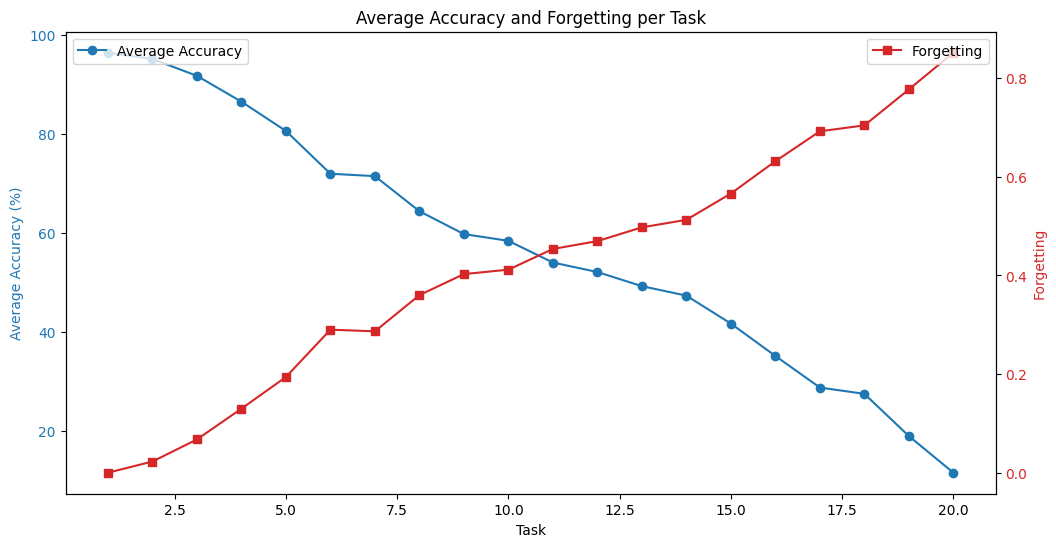

In [ ]:
import matplotlib.pyplot as plt

# Data for each task
tasks = list(range(1, 21))  # Task numbers from 1 to 20
average_accuracy =[
    96.34, 95.07, 91.68, 86.46, 80.56, 71.925, 71.44142857142857,
    64.3625, 59.75111111111111, 58.386, 54.01090909090909, 52.0975,
    49.24307692307692, 47.332142857142856, 41.68933333333334, 35.1625,
    28.78529411764706, 27.51833333333333, 18.997894736842103, 11.6035
]
forgetting = [
    0.0, 0.022700000000000102, 0.06744999999999997, 0.12986666666666669,
    0.19400000000000003, 0.29005999999999993, 0.28664999999999996, 0.36010000000000003,
    0.40275000000000005, 0.4117333333333334, 0.4536800000000001, 0.469609090909091,
    0.49751666666666666, 0.5127076923076924, 0.5661071428571428, 0.6315933333333335,
    0.6922875000000001, 0.7042705882352942, 0.7771666666666667, 0.8515736842105264
]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average accuracy
color = 'tab:blue'
ax1.set_xlabel('Task')
ax1.set_ylabel('Average Accuracy (%)', color=color)
ax1.plot(tasks, average_accuracy, 'o-', color=color, label='Average Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot forgetting
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Forgetting', color=color)
ax2.plot(tasks, forgetting, 's-', color=color, label='Forgetting')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Average Accuracy and Forgetting per Task')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Rest of the plotting code


In [ ]:
rot mnist

In [ ]:
---- Task 1 (OCS) ----
OCS >> (average accuracy): 97.86
OCS >> (Forgetting): 0.0
Maximum per-task accuracies: [97.86]

---- Task 2 (OCS) ----
OCS >> (average accuracy): 97.37
OCS >> (Forgetting): 0.011700000000000018
Maximum per-task accuracies: [97.86]

---- Task 3 (OCS) ----
OCS >> (average accuracy): 95.64333333333333
OCS >> (Forgetting): 0.03375
Maximum per-task accuracies: [97.86]

---- Task 4 (OCS) ----
OCS >> (average accuracy): 92.52250000000001
OCS >> (Forgetting): 0.07119999999999994
Maximum per-task accuracies: [97.86]

---- Task 5 (OCS) ----
OCS >> (average accuracy): 88.26599999999999
OCS >> (Forgetting): 0.11939999999999998
Maximum per-task accuracies: [97.86]

---- Task 6 (OCS) ----
OCS >> (average accuracy): 82.74166666666666
OCS >> (Forgetting): 0.1802
Maximum per-task accuracies: [97.86]

---- Task 7 (OCS) ----
OCS >> (average accuracy): 78.38857142857144
OCS >> (Forgetting): 0.2254166666666667
Maximum per-task accuracies: [97.86]

---- Task 8 (OCS) ----
OCS >> (average accuracy): 72.27125000000001
OCS >> (Forgetting): 0.2900142857142858
Maximum per-task accuracies: [97.86]

---- Task 9 (OCS) ----
OCS >> (average accuracy): 69.60777777777777
OCS >> (Forgetting): 0.3138375
Maximum per-task accuracies: [97.86]

---- Task 10 (OCS) ----
OCS >> (average accuracy): 66.56800000000001
OCS >> (Forgetting): 0.3426444444444444
Maximum per-task accuracies: [97.86]

---- Task 11 (OCS) ----
OCS >> (average accuracy): 62.862727272727284
OCS >> (Forgetting): 0.3762
Maximum per-task accuracies: [97.86]

---- Task 12 (OCS) ----
OCS >> (average accuracy): 61.919999999999995
OCS >> (Forgetting): 0.3831636363636364
Maximum per-task accuracies: [97.86]

---- Task 13 (OCS) ----
OCS >> (average accuracy): 58.15538461538462
OCS >> (Forgetting): 0.4221999999999999
Maximum per-task accuracies: [97.86]

---- Task 14 (OCS) ----
OCS >> (average accuracy): 57.738571428571426
OCS >> (Forgetting): 0.41934615384615376
Maximum per-task accuracies: [97.86]

---- Task 15 (OCS) ----
OCS >> (average accuracy): 55.688
OCS >> (Forgetting): 0.4362357142857143
Maximum per-task accuracies: [97.86]

---- Task 16 (OCS) ----
OCS >> (average accuracy): 52.900000000000006
OCS >> (Forgetting): 0.4622933333333333
Maximum per-task accuracies: [97.86]

---- Task 17 (OCS) ----
OCS >> (average accuracy): 50.43058823529412
OCS >> (Forgetting): 0.48718125
Maximum per-task accuracies: [97.86]

---- Task 18 (OCS) ----
OCS >> (average accuracy): 39.75333333333333
OCS >> (Forgetting): 0.5918764705882353
Maximum per-task accuracies: [97.86]

---- Task 19 (OCS) ----
OCS >> (average accuracy): 38.33736842105263
OCS >> (Forgetting): 0.5993055555555555
Maximum per-task accuracies: [97.86]

---- Task 20 (OCS) ----
OCS >> (average accuracy): 14.636500000000002
OCS >> (Forgetting): 0.835205263157895
Maximum per-task accuracies: [97.86]


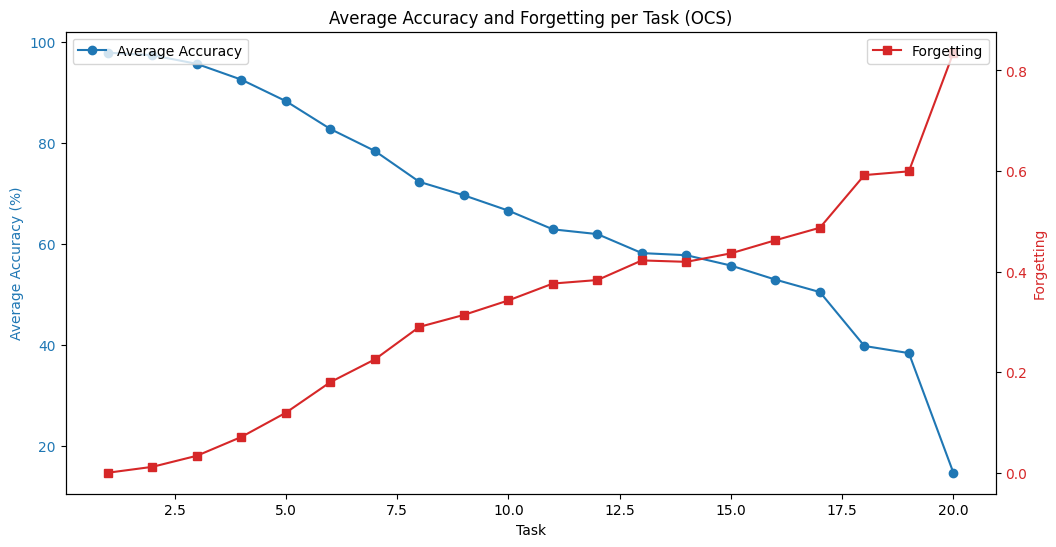

In [ ]:
import matplotlib.pyplot as plt

# Updated data for each task
tasks = list(range(1, 21))  # Task numbers from 1 to 20
average_accuracies = [
    97.86, 97.37, 95.64333333333333, 92.52250000000001, 88.26599999999999, 82.74166666666666,
    78.38857142857144, 72.27125000000001, 69.60777777777777, 66.56800000000001, 62.862727272727284,
    61.919999999999995, 58.15538461538462, 57.738571428571426, 55.688, 52.900000000000006,
    50.43058823529412, 39.75333333333333, 38.33736842105263, 14.636500000000002
]
forgetting = [
    0.0, 0.011700000000000018, 0.03375, 0.07119999999999994, 0.11939999999999998, 0.1802,
    0.2254166666666667, 0.2900142857142858, 0.3138375, 0.3426444444444444, 0.3762, 0.3831636363636364,
    0.4221999999999999, 0.41934615384615376, 0.4362357142857143, 0.4622933333333333, 0.48718125,
    0.5918764705882353, 0.5993055555555555, 0.835205263157895
]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average accuracy
color = 'tab:blue'
ax1.set_xlabel('Task')
ax1.set_ylabel('Average Accuracy (%)', color=color)
ax1.plot(tasks, average_accuracies, 'o-', color=color, label='Average Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot forgetting
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Forgetting', color=color)
ax2.plot(tasks, forgetting, 's-', color=color, label='Forgetting')
ax2.tick_params(axis='y', labelcolor=color)

# Title and legend
plt.title('Average Accuracy and Forgetting per Task (OCS)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()
